In [5]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression


pd.set_option('display.max_columns', 20)
seed = 143

import warnings
warnings.filterwarnings("ignore")

model = LogisticRegression()


# 3. Model with Logistic Regression

Read preprocessed data

In [3]:
df_X_train = pd.read_csv('df_X_train.csv')
df_X_test = pd.read_csv('df_X_test.csv')
df_y_train = pd.read_csv('df_y_train.csv')
df_y_test = pd.read_csv('df_y_test.csv')
print(df_X_train.info())
print(df_y_train.info())

# drop the unnamed ID column
df_X_train.drop('Unnamed: 0', axis=1, inplace=True)
df_X_test.drop('Unnamed: 0', axis=1, inplace=True)
df_y_train.drop('Unnamed: 0', axis=1, inplace=True)
df_y_test.drop('Unnamed: 0', axis=1, inplace=True)

df_X_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           506 non-null    int64  
 1   duration             506 non-null    float64
 2   credit_amount        506 non-null    float64
 3   installment_rate     506 non-null    float64
 4   residence_length     506 non-null    float64
 5   age                  506 non-null    float64
 6   existing_credits     506 non-null    float64
 7   liable_people        506 non-null    float64
 8   checking_account_1   506 non-null    float64
 9   checking_account_2   506 non-null    float64
 10  checking_account_3   506 non-null    float64
 11  checking_account_4   506 non-null    float64
 12  credit_history_1     506 non-null    float64
 13  credit_history_2     506 non-null    float64
 14  credit_history_3     506 non-null    float64
 15  credit_history_4     506 non-null    flo

,duration,credit_amount,installment_rate,residence_length,age,existing_credits,liable_people,checking_account_1,checking_account_2,checking_account_3,...,housing_2,housing_3,job_1,job_2,job_3,job_4,telephone_1,telephone_2,foreign_worker_1,foreign_worker_2
0,0.294118,0.062012,1.000000,0.333333,0.500000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.250000,0.160119,1.000000,0.666667,0.392857,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.205882,0.172114,0.333333,0.000000,0.214286,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.161765,0.070540,1.000000,0.666667,0.214286,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.294118,0.347639,0.333333,0.333333,0.035714,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


### 3.1 Tune hyperparameters using GridSearchCV

In [6]:
hyperparam_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

model_bestparam = grid_search.best_estimator_
print(model_bestparam)

Fitting 15 folds for each of 45 candidates, totalling 675 fits
0.7739013200051261
{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(solver='newton-cg')
LogisticRegression(solver='newton-cg')


### 3.2 Fit the model, predict probability of default (PD)

In [9]:
preds = model_bestparam.predict_proba(df_X_test)
df_preds = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.5
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_test, df_preds['Risk_pred']))
print(classification_report(df_y_test, df_preds['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_test, df_preds['Risk_pred']))



[[106  47]
 [ 10  37]]
              precision    recall  f1-score   support

        good       0.91      0.69      0.79       153
         bad       0.44      0.79      0.56        47

    accuracy                           0.71       200
   macro avg       0.68      0.74      0.68       200
weighted avg       0.80      0.71      0.74       200

0.7400222500347656


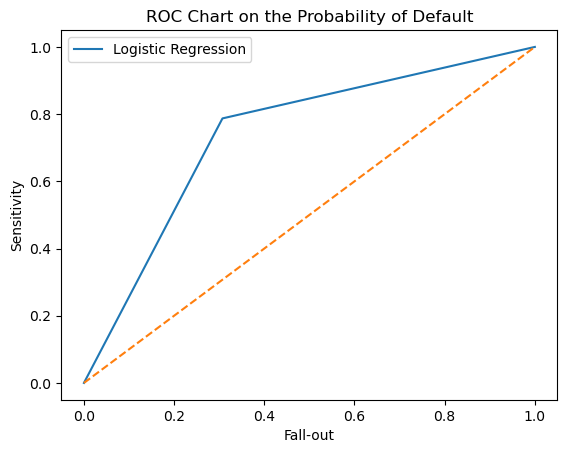

In [8]:
fallout, sensitivity, thresholds = roc_curve(df_y_test, df_preds['Risk_pred'])
plt.plot(fallout, sensitivity, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
     